In [1]:
#clean up in v02 and run tests
#v03 cleaner

import pandas as pd
import os
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, regularizers
from helper_functions.testing_functions import accuracy_distance, accuracy_moneyline, accuracy_ou
from helper_functions.simulate_game import simulate_game
from helper_functions.combine_matrices import combine_team_matrix
from tensorflow.keras.losses import Loss
import seaborn as sns
import pickle

In [2]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [3]:
def pull_game_data(g):
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')

        A_score = game_res.iloc[-1]['Home']
        B_score = game_res.iloc[-1]['Away']
        score = (A_score,B_score)

        return matrix1, matrix2, score

In [4]:
#load game data
ma_list = []
mb_list = []
output_list = []

for game in tqdm(os.listdir('raw_game_pulls')):
    a,b,c = pull_game_data(game)
    ma_list.append(a)
    mb_list.append(b)
    output_list.append(c)

  0%|          | 0/5498 [00:00<?, ?it/s]

100%|██████████| 5498/5498 [03:39<00:00, 24.99it/s]


In [5]:
#going to zip these into dicts to access by game ID
game_ids = []
for game in tqdm(os.listdir('raw_game_pulls')):
    game_ids.append(game.split('_')[0])


#FINAL RAW DICTS
team_A_matrices_raw = dict(zip(game_ids, ma_list))
team_B_matrices_raw = dict(zip(game_ids, mb_list))
outputs_raw = dict(zip(game_ids, output_list))

100%|██████████| 5498/5498 [00:00<00:00, 2752480.71it/s]


In [19]:
#transform regular output data into argmax array form
arr_outputs = []
for x in output_list:
    value1, value2 = x

    # Create numpy arrays
    array1 = np.zeros(201)
    array2 = np.zeros(201)

    # Set the corresponding indices to 1
    array1[value1 - 1] = 1
    array2[value2 - 1] = 1 
    arr_outputs.append((array1, array2))

#FINAL ARRAY DICT
outputs_array = dict(zip(game_ids, arr_outputs))

In [20]:
#normalize inputs ###############################################################################
#save these matrices down for normalizing function
all_inputs=ma_list+mb_list

arr = np.array([df.values for df in all_inputs])

# Calculate mean and standard deviation across the first axis (which represents different DataFrames)
avg = np.mean(arr, axis=0)
std_dev = np.std(arr, axis=0)

# Create DataFrames from the calculated arrays
avg_df = pd.DataFrame(avg, index=all_inputs[0].index, columns=all_inputs[0].columns)
std_dev_df = pd.DataFrame(std_dev, index=all_inputs[0].index, columns=all_inputs[0].columns)

with open('helper_functions/avg_input_matrix.pickle', 'wb') as file:
    pickle.dump(avg_df, file)

with open('helper_functions/std_input_matrix.pickle', 'wb') as file:
    pickle.dump(std_dev_df, file)



norm_inputs_a = []
norm_inputs_b = []

#Normalize each value in each matrix
for matrix in ma_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_a.append(normalized_matrix)

for matrix in mb_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_b.append(normalized_matrix)


#NORMALIZED MATRIX DICTS
team_A_matrices_normal = dict(zip(game_ids, norm_inputs_a))
team_B_matrices_normal = dict(zip(game_ids, norm_inputs_b))

In [8]:
#load saved simulations into dicts with game ID and 1000 scores
saved_sim_ids = [x.split('.')[0] for x in os.listdir('saved_sims_small')]
simulated_scores = []
for x in  os.listdir('saved_sims_small'):
    with open('saved_sims_small/{}'.format(x), 'rb') as file:
        data=pickle.load(file)
        simulated_scores.append(data)
simulated_scores_dict = dict(zip(saved_sim_ids, simulated_scores))

In [9]:
#train test split on simulated score game IDS 
train_index, test_index = train_test_split(list(simulated_scores_dict.keys()), test_size=0.2)

In [10]:
#matrix_A_train is list of normalized input matrices used for training NN
matrix_A_train = [team_A_matrices_normal[x] for x in train_index]
matrix_B_train = [team_B_matrices_normal[x] for x in train_index]


#y_train is training list of argmax formatted outputs
y_train = [outputs_array[x] for x in train_index]

#matrix_A_test is list of normalized input matrices used for testing NN
matrix_A_test = [team_A_matrices_normal[x] for x in test_index]
matrix_B_test = [team_B_matrices_normal[x] for x in test_index]

#y_test is testing list of argmax formatted outputs
y_test=[outputs_array[x] for x in test_index]

#get testing versions of raw outputs (not for NN testing, just accuracy calcs)
final_scores_test = [outputs_raw[x] for x in test_index]

#do same as above for regular simulation testing - not normalized and no training data needed
simulation_output_test = [simulated_scores_dict[x] for x in test_index]

In [11]:
def test_nn_output(model, game_index, num_sims):
    #Pull and Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[test_index.index(game_index)].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[test_index.index(game_index)].values.reshape(-1, 18, 18)

    predictions = model.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    home_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][0])
    away_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[1][0])

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=game_index
    return current_df

In [12]:
#not working right now
# Define custom loss function
class Distance(Loss):
    def call(self, y_true, y_pred):
        # Reshape the input tensors if necessary
        y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
        y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

        # Compute the argmax operation with the correct axis
        a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
        b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

        # Compute the argmax operation for the true labels as well
        a_true = tf.argmax(y_true_reshaped[0], axis=1)
        b_true = tf.argmax(y_true_reshaped[1], axis=1)

        # Compute the loss based on the difference between predicted and true values

        global loss
        global egg
        # egg = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
        loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
        # return egg

        return loss

In [13]:
# #attempting to train with customized loss function
# def custom_loss(y_true, y_pred,):
#     # Reshape the input tensors if necessary
#     y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
#     y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

#     # Compute the argmax operation with the correct axis
#     a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
#     b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

#     # Compute the argmax operation for the true labels as well
#     a_true = tf.argmax(y_true_reshaped[0], axis=1)
#     b_true = tf.argmax(y_true_reshaped[1], axis=1)

#     # Compute the loss based on the difference between predicted and true values
#     loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
#     return loss

In [14]:
#variables list

#ALL GAMES:
#team_A_matrices_raw - dict of key: game_id, val: home team matrix
#team_B_matrices_raw - dict of key: game_id, val: away team matrix
#outputs_raw - dict of key: game_id, val: final score tuple
#outputs_array - dict of key: game_id, val: array version of output (one-hot format)
#team_A_matrices_normal - dict of key: game_id, val: normalized home team matrix
#team_B_matrices_normal - dict of key: game_id, val: normalized away team matrix

#saved_sim_ids - list of game IDS in simulated data
#simulated_scores_dict - dict of key: game_id, val: list of 1000 score tuples

#train_index, test_index - lists of game id's for training and testing

#TRAINING GAMES:
#matrix_A_train - list of normalized home team matrices for training
#matrix_B_train - list of normalized away team matrices for training
#y_train - list of one-hot outputs for training

#TESTING GAMES:
#matrix_A_test - list of normalized home team matrices for testing
#matrix_B_test - list of normalized away team matrices for testing
#y_test - list of one-hot outputs for testing

#simulation_output_test - list of 1000 score tuples for testing
#final_scores_test - 

In [15]:
# Define the neural network architecture
def build_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    dense1 = layers.Dense(200, activation='relu')(concat)
    dense2 = layers.Dense(100, activation='relu')(dense1)

    output1 = layers.Dense(201, activation='softmax', name='output1')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

# Define your training function
def train_model(model_function, matrixA_list, matrixB_list, output_tuple_list, epochs=10, batch_size=32):
    # Convert DataFrame to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Build the model
    model = model_function()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit([matrixA_array, matrixB_array], [output_array[:, 0], output_array[:, 1]], epochs=epochs, batch_size=batch_size)
    return model

In [16]:
m1 = train_model(build_model, matrix_A_train, matrix_B_train, y_train, 10, 64)



Epoch 1/10


69/69 [==============================] - 1s 2ms/step - loss: 8.9587 - output1_loss: 4.5277 - output2_loss: 4.4309 - output1_accuracy: 0.0271 - output2_accuracy: 0.0262
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 7.6873 - output1_loss: 3.8911 - output2_loss: 3.7961 - output1_accuracy: 0.0682 - output2_accuracy: 0.0669
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 7.2874 - output1_loss: 3.6837 - output2_loss: 3.6037 - output1_accuracy: 0.0964 - output2_accuracy: 0.1078
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 6.9128 - output1_loss: 3.4860 - output2_loss: 3.4267 - output1_accuracy: 0.1383 - output2_accuracy: 0.1415
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 6.5715 - output1_loss: 3.3036 - output2_loss: 3.2679 - output1_accuracy: 0.1710 - output2_accuracy: 0.1824
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 6.2527 - output1_loss: 3.1410

In [18]:
with open('models/nn1.pickle', 'wb') as handle:
    pickle.dump(m1, handle)

In [18]:
# predicted_scores = []
# all_predictions_list = []

# for i in tqdm(range(len(matrix_A_test))):
#     # Convert test matrices to numpy arrays
#     test_matrix_a_array = matrix_A_test[i].values.reshape(-1, 18, 18)
#     test_matrix_b_array = matrix_B_test[i].values.reshape(-1, 18, 18)

#     # Make predictions using the model
#     predictions = m1.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)
#     all_predictions_list.append(predictions)

#     predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))

#     predicted_scores.append(predicted_score)

In [13]:
#design test for outputs - we have ~1200 test games
#one approach - run simulation 10-100 times for each, find overall accuracy, test against argmax values
#one approach - run simulation 10 times for each, run random weighted choice 10 times for each, compare

In [19]:
def calc_dist(x1,x2,y1,y2):
    return np.sqrt((x1-y1)**2 + (x2-y2)**2)

def calc_ou(x1,x2,y1,y2):
    return (y1+y2) - (x1+x2)

def calc_winner(x1,x2,y1,y2):
    return (x1>x2)==(y1>y2)

def calc_score(data, var='Distance'):
    if var == 'Distance':
        func = np.vectorize(calc_dist)
    elif var == 'OU':
        func=np.vectorize(calc_ou)
    elif var == 'Winner':
        func=np.vectorize(calc_winner)

    result = func(data['Real Home Score'],
                    data['Real Away Score'],
                    data['Projected Home Score'],
                    data['Projected Away Score'])
    return result

In [65]:
data_list = []
for g in tqdm(range(len(final_scores_test))):
    real_score = final_scores_test[g]
    current_1000 = simulation_output_test[g]
    current_df = pd.DataFrame(current_1000, columns=['Projected Home Score','Projected Away Score'])
    current_df['Game'] = test_index[g]
    current_df['Real Home Score'] = real_score[0]
    current_df['Real Away Score'] = real_score[1]
    data_list.append(current_df)
testing_dataframe = pd.concat(data_list).reset_index(drop=True)

  0%|          | 0/1100 [00:00<?, ?it/s]

100%|██████████| 1100/1100 [00:01<00:00, 887.98it/s]


In [66]:
testing_dataframe['Distance'] = calc_score(testing_dataframe)
testing_dataframe['OU'] = calc_score(testing_dataframe, 'OU')
testing_dataframe['Winner'] = calc_score(testing_dataframe, 'Winner')

In [67]:
testing_df_grouped = testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()

In [70]:
data_list_2 = []
for gid in tqdm(test_index):
    real_score = final_scores_test[test_index.index(gid)]
    current_nn_test = test_nn_output(m1, gid, 1000)
    current_nn_test=current_nn_test.rename(columns={'Home':'Projected Home Score',
                                                'Away':'Projected Away Score'})
    current_nn_test['Real Home Score'] = real_score[0]
    current_nn_test['Real Away Score'] = real_score[1]

    data_list_2.append(current_nn_test)

100%|██████████| 1100/1100 [00:48<00:00, 22.48it/s]


In [71]:
nn_testing_dataframe = pd.concat(data_list_2)

In [72]:
nn_testing_dataframe['Distance'] = calc_score(nn_testing_dataframe)
nn_testing_dataframe['OU'] = calc_score(nn_testing_dataframe, 'OU')
nn_testing_dataframe['Winner'] = calc_score(nn_testing_dataframe, 'Winner')

In [74]:
nn_testing_df_grouped = nn_testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()

In [76]:
models_dict=dict()
models_dict['sim']=testing_df_grouped
# models_dict['nn']=nn_testing_df_grouped

In [77]:
plot_data=dict()
for var in ['Distance','OU','Winner']:
    curr_dict=dict()
    for model in models_dict.keys():
        temp_df=models_dict[model][['Game',var]]
        temp_df=temp_df.rename(columns={var:var+'_{}'.format(model)})
        curr_dict[model]=temp_df
    base_df=list(curr_dict.values())[0]
    for df in list(curr_dict.values())[1:]:
        base_df=base_df.merge(df, on='Game')
    plot_data[var]=base_df


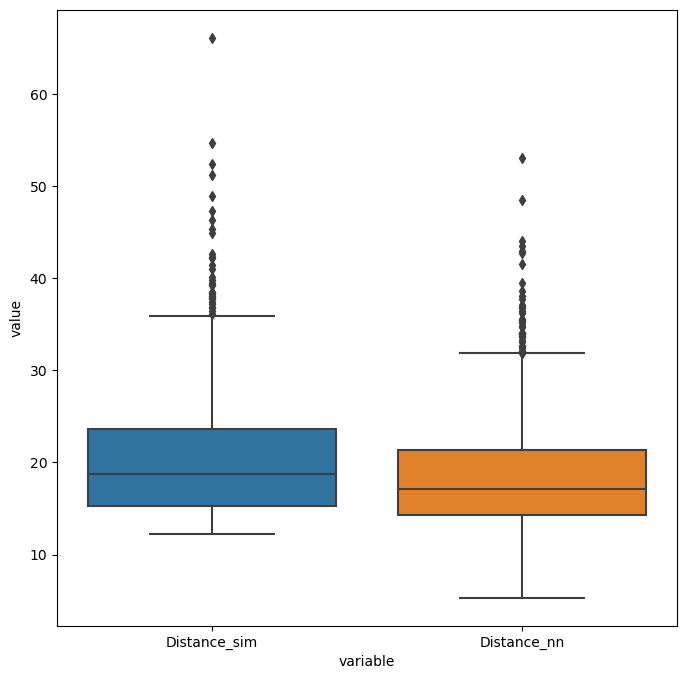

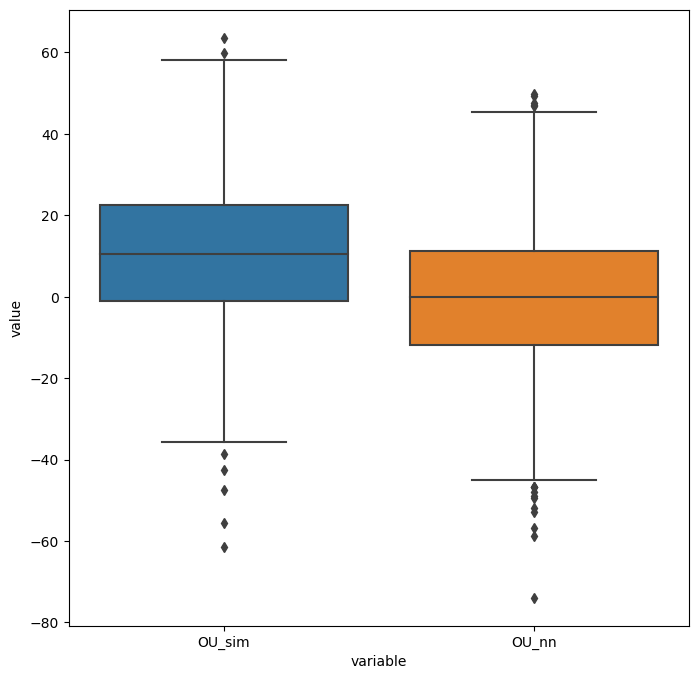

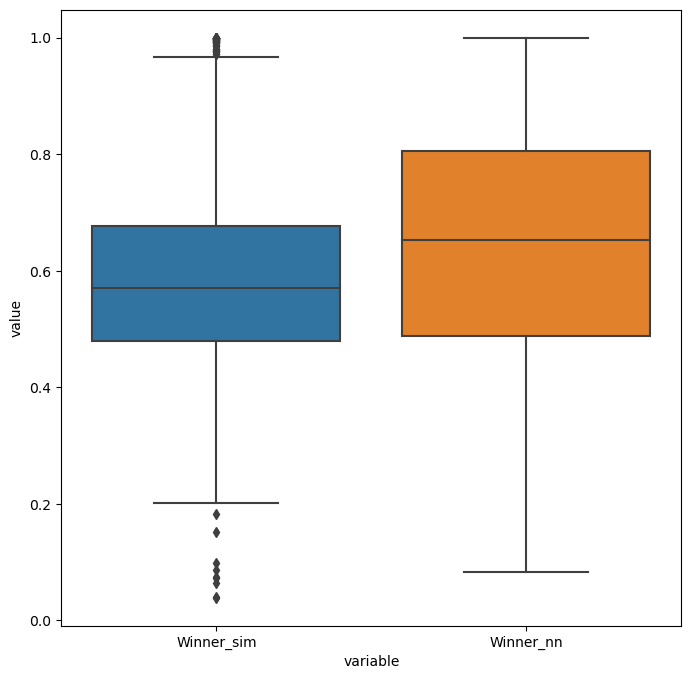

In [79]:
for v in plot_data.values():
    fig, ax=plt.subplots(figsize=(8,8))
    to_plot=v.melt(id_vars='Game')
    sns.boxplot(x='variable',y='value',data=to_plot)
    plt.show()

In [ ]:
#above looks good.
#add 2 more nn archs and generalize 

In [107]:
def build_regularized_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    
    # Wide sparse layers with L1 regularization
    dense1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.01))(concat)
    dropout1 = layers.Dropout(0.5)(dense1)
    
    dense2 = layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01))(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)

    output1 = layers.Dense(201, activation='softmax', name='output1')(dropout2)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(dropout2)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

In [108]:
m2 = train_model(build_regularized_model, matrix_A_train, matrix_B_train, y_train, 10, 64)

Epoch 1/10
69/69 [==============================] - 2s 8ms/step - loss: 78.5857 - output1_loss: 4.3596 - output2_loss: 4.2907 - output1_accuracy: 0.0266 - output2_accuracy: 0.0312
Epoch 2/10
69/69 [==============================] - 0s 7ms/step - loss: 9.8405 - output1_loss: 4.1409 - output2_loss: 4.0446 - output1_accuracy: 0.0316 - output2_accuracy: 0.0305
Epoch 3/10
69/69 [==============================] - 0s 7ms/step - loss: 8.7411 - output1_loss: 4.1396 - output2_loss: 4.0299 - output1_accuracy: 0.0237 - output2_accuracy: 0.0371
Epoch 4/10
69/69 [==============================] - 0s 7ms/step - loss: 8.7159 - output1_loss: 4.1252 - output2_loss: 4.0268 - output1_accuracy: 0.0309 - output2_accuracy: 0.0307
Epoch 5/10
69/69 [==============================] - 0s 7ms/step - loss: 8.6829 - output1_loss: 4.1111 - output2_loss: 4.0105 - output1_accuracy: 0.0296 - output2_accuracy: 0.0327
Epoch 6/10
69/69 [==============================] - 0s 7ms/step - loss: 8.6789 - output1_loss: 4.1033 - 

In [151]:
def build_model_3():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    dense1 = layers.Dense(69, activation='relu')(concat)
    dense2 = layers.Dense(6969, activation='relu')(dense1)
    dense3 = layers.Dense(123, activation='relu')(concat)




    output1 = layers.Dense(201, activation='softmax', name='output1')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

In [152]:
m6=train_model(build_model_3, matrix_A_train, matrix_B_train, y_train, 16, 64)

In [135]:
nn_list=[m1,m3, m4]

In [ ]:
nn_list = [m4]

In [136]:
# models_dict=dict()
# models_dict['sim']=testing_df_grouped

for model_num in range(len(nn_list)):    
    current_data_list = []
    for gid in tqdm(test_index):
        real_score = final_scores_test[test_index.index(gid)]
        current_nn_test = test_nn_output(nn_list[model_num], gid, 100)
        current_nn_test=current_nn_test.rename(columns={'Home':'Projected Home Score',
                                                    'Away':'Projected Away Score'})
        current_nn_test['Real Home Score'] = real_score[0]
        current_nn_test['Real Away Score'] = real_score[1]

        current_data_list.append(current_nn_test)

    nn_testing_dataframe = pd.concat(current_data_list)

    nn_testing_dataframe['Distance'] = calc_score(nn_testing_dataframe)
    nn_testing_dataframe['OU'] = calc_score(nn_testing_dataframe, 'OU')
    nn_testing_dataframe['Winner'] = calc_score(nn_testing_dataframe, 'Winner')

    nn_testing_df_grouped = nn_testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
    models_dict['nn_{}'.format(model_num)]=nn_testing_df_grouped

  0%|          | 0/1100 [00:00<?, ?it/s]

100%|██████████| 1100/1100 [00:44<00:00, 24.85it/s]


In [137]:
plot_data=dict()
for var in ['Distance','OU','Winner']:
    curr_dict=dict()
    for model in models_dict.keys():
        temp_df=models_dict[model][['Game',var]]
        temp_df=temp_df.rename(columns={var:var+'_{}'.format(model)})
        curr_dict[model]=temp_df
    base_df=list(curr_dict.values())[0]
    for df in list(curr_dict.values())[1:]:
        base_df=base_df.merge(df, on='Game')
    plot_data[var]=base_df


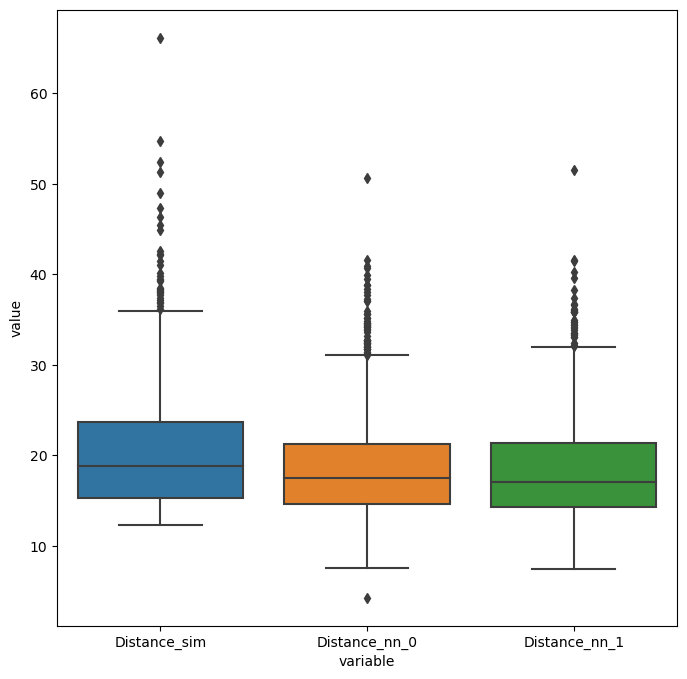

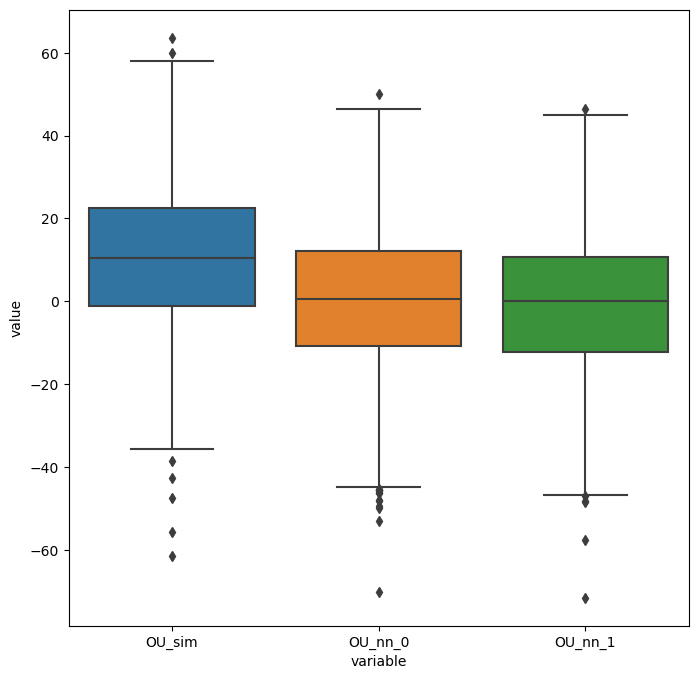

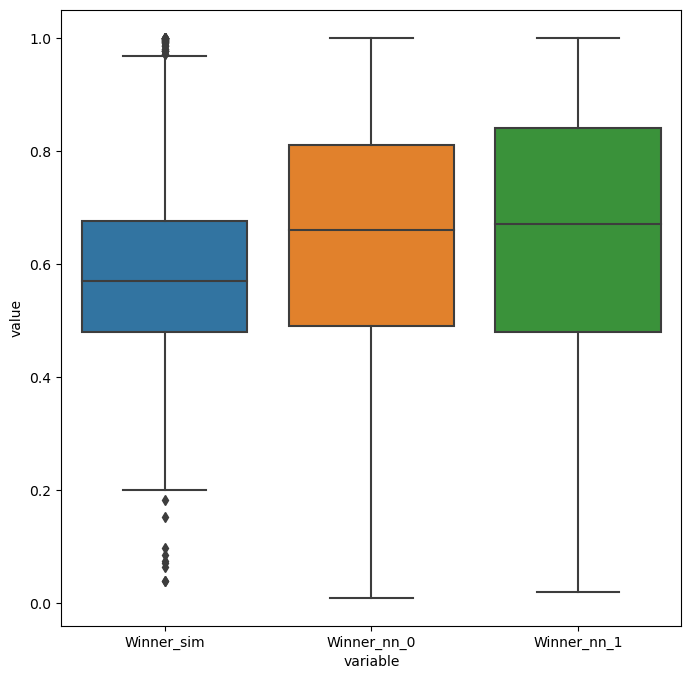

In [138]:
for v in plot_data.values():
    fig, ax=plt.subplots(figsize=(8,8))
    to_plot=v.melt(id_vars='Game')
    sns.boxplot(x='variable',y='value',data=to_plot)
    plt.show()

In [95]:
models_dict['nn_2']

,Game,Distance,OU,Winner
0,6195971,18.473217,17.0,0.8
1,6195976,15.537389,6.8,1.0
2,6195979,23.021729,-6.0,0.0
3,6195986,7.071068,8.0,1.0
4,6195990,12.286107,-4.6,0.8
...,...,...,...,...
1095,6201772,14.253170,-19.4,1.0
1096,6201778,16.906588,-7.0,0.2
1097,6201780,5.200000,-3.6,0.8
1098,6201783,13.892444,-5.0,1.0


In [91]:
nn_testing_dataframe[nn_testing_dataframe['Game']=='6195986']

,Projected Home Score,Projected Away Score,Game,Real Home Score,Real Away Score,Distance,OU,Winner
0,81,59,6195986,59,58,22.022716,23,True
1,66,59,6195986,59,58,7.071068,8,True
2,66,59,6195986,59,58,7.071068,8,True
3,66,59,6195986,59,58,7.071068,8,True
4,66,59,6195986,59,58,7.071068,8,True
...,...,...,...,...,...,...,...,...
995,66,59,6195986,59,58,7.071068,8,True
996,66,59,6195986,59,58,7.071068,8,True
997,66,59,6195986,59,58,7.071068,8,True
998,81,59,6195986,59,58,22.022716,23,True
